In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
import seaborn as sns

import graphviz
import plotly.express as px
import plotly.graph_objects as go
from dtreeviz.trees import dtreeviz
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree

from IPython.display import Image

FIG_WIDTH = 1280
FIG_HEIGHT = 720

random_state = 13

def plot_figure(fig, static=True):
    fig.update_layout(width=FIG_WIDTH, height=FIG_HEIGHT)
    if static:
        img_bytes = fig.to_image(format="png")
        return Image(img_bytes)
    else:
        fig.show()

# Loading train and test data

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

X_train = train_df.drop("Machine failure", axis="columns")
X_test = test_df.drop("Machine failure", axis="columns")

features = X_train.columns.to_list()
target = "Machine failure"

y_train = train_df[target]
y_test = test_df[target]

# Decision Tree Classifier - Simple

In [3]:
tree_clf = DecisionTreeClassifier(class_weight="balanced", max_depth=3, random_state=random_state)
tree_clf = tree_clf.fit(X_train, y_train)

In [4]:
y_train_pred = tree_clf.predict(X_train)
y_test_pred = tree_clf.predict(X_test)

print("------- Train set -------")
print(f"Precision: {precision_score(y_train, y_train_pred)}")
print(f"Recall: {recall_score(y_train, y_train_pred)}")
print(f"F1: {f1_score(y_train, y_train_pred)}")

print("------- Test set -------")
print(f"Precision: {precision_score(y_test, y_test_pred)}")
print(f"Recall: {recall_score(y_test, y_test_pred)}")
print(f"F1: {f1_score(y_test, y_test_pred)}")

------- Train set -------
Precision: 0.25874125874125875
Recall: 0.8191881918819188
F1: 0.3932683790965456
------- Test set -------
Precision: 0.2412280701754386
Recall: 0.8088235294117647
F1: 0.37162162162162166


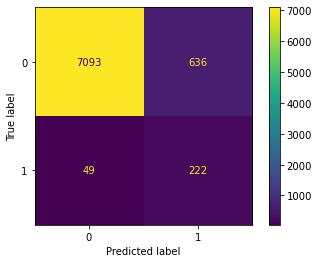

In [5]:
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=tree_clf.classes_)
disp.plot()

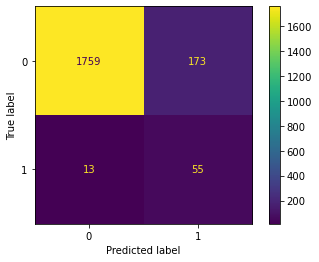

In [6]:
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=tree_clf.classes_)
disp.plot()

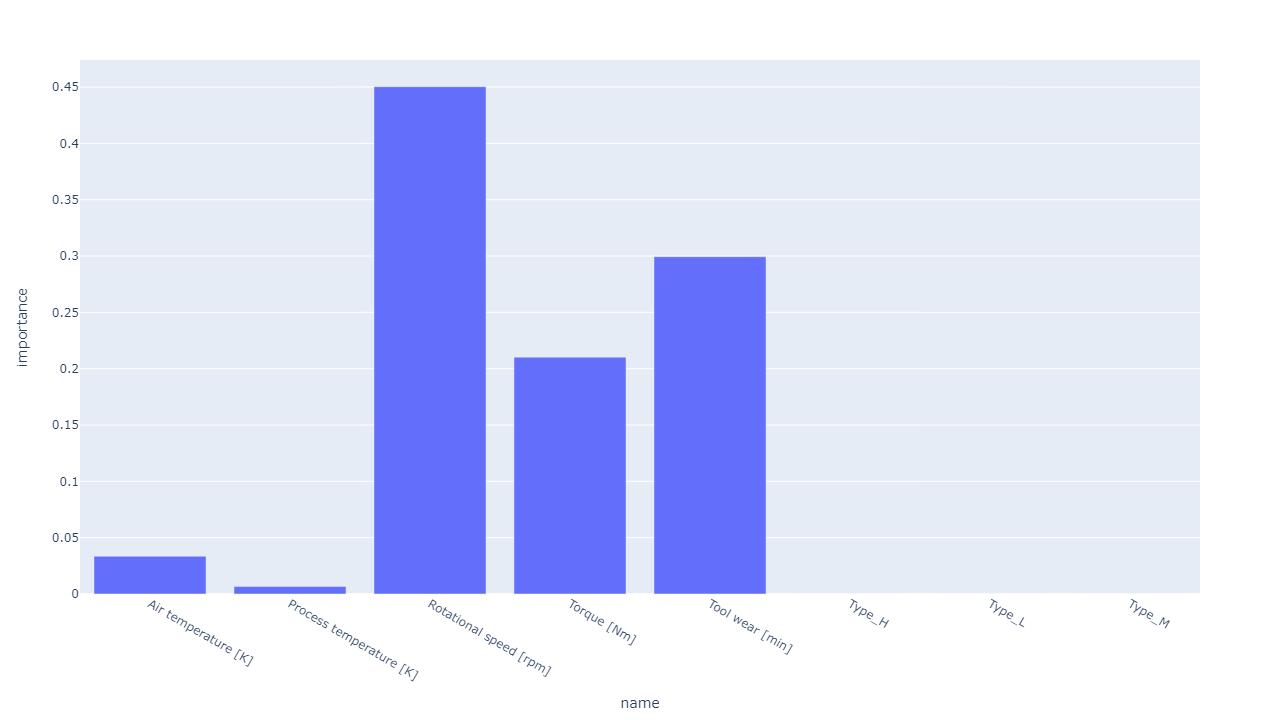

In [7]:
feature_importance = pd.DataFrame({"name": X_train.columns, "importance": tree_clf.feature_importances_})
fig = px.bar(feature_importance, x="name", y="importance")
plot_figure(fig)

In [8]:
TP_samples = (y_test == 0) & (y_test == y_test_pred)
TN_samples = (y_test == 1) & (y_test == y_test_pred)
FN_samples = (y_test == 0) & (y_test != y_test_pred)
FP_samples = (y_test == 1) & (y_test != y_test_pred)

X_TP = X_test.iloc[np.argmax(TP_samples)]
X_TN = X_test.iloc[np.argmax(TN_samples)]
X_FN = X_test.iloc[np.argmax(FN_samples)]
X_FP = X_test.iloc[np.argmax(FP_samples)]

In [9]:
sk_dtree = ShadowSKDTree(tree_clf, X_test, y_test, features, target_name="Machine status", class_names=["OK","Failure"])

In [10]:
colors_for_up_to_2_classes = [None,  # 0 classes
                              None,  # 1 class
                              px.colors.qualitative.Plotly[0:2]
                              ]

c:\Users\Henning\miniconda3\envs\predictive_maintenance\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



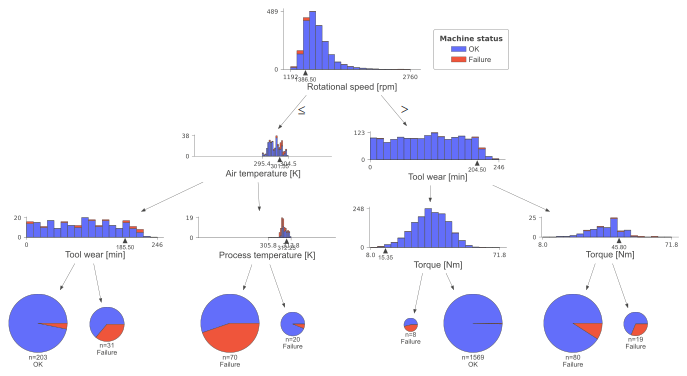

In [11]:
dtreeviz(sk_dtree, colors={'classes': colors_for_up_to_2_classes})

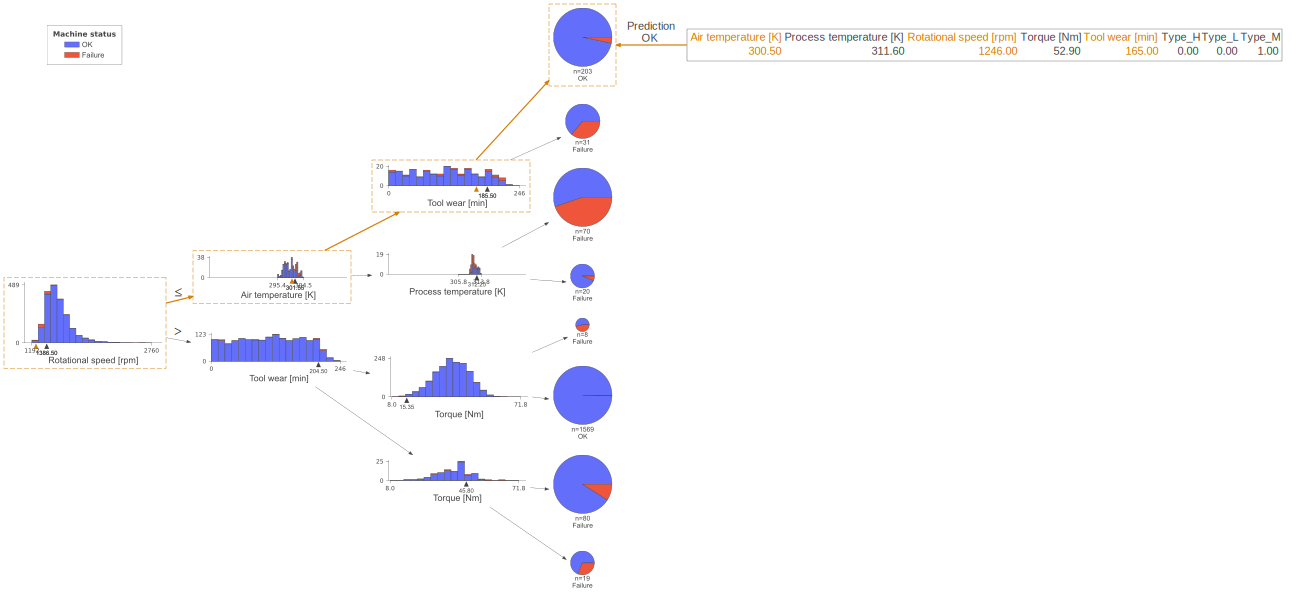

In [12]:
dtreeviz(sk_dtree, orientation ='LR', X = X_TP, colors={'classes': colors_for_up_to_2_classes})

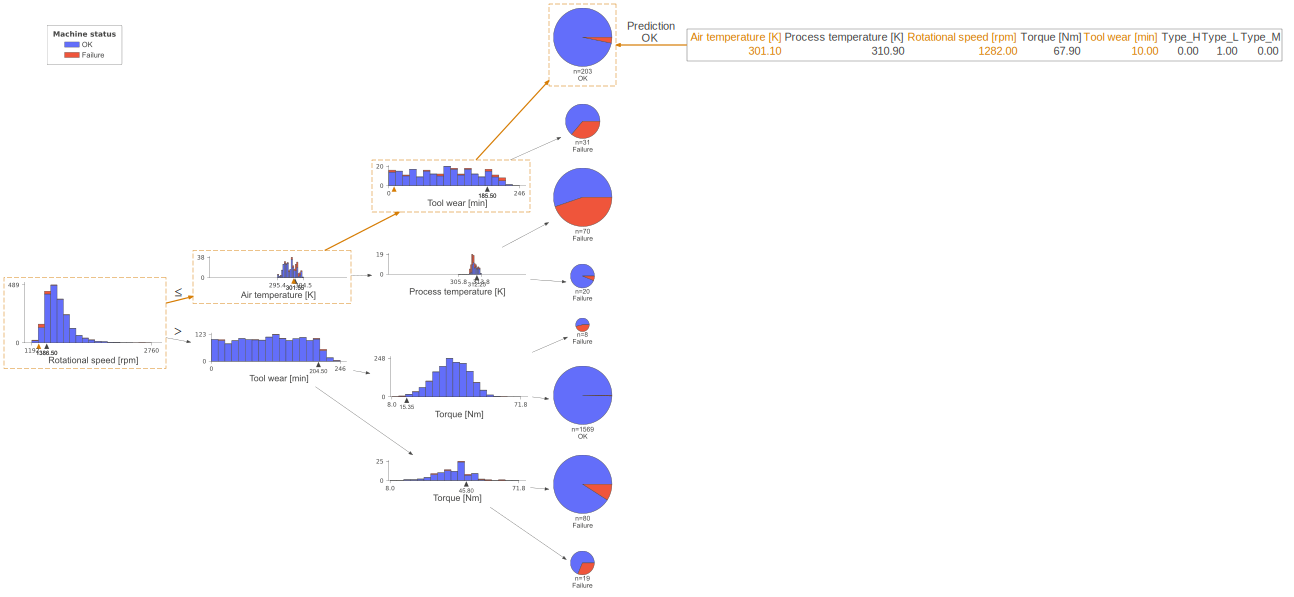

In [13]:
dtreeviz(sk_dtree, orientation ='LR', X = X_FP, colors={'classes': colors_for_up_to_2_classes})

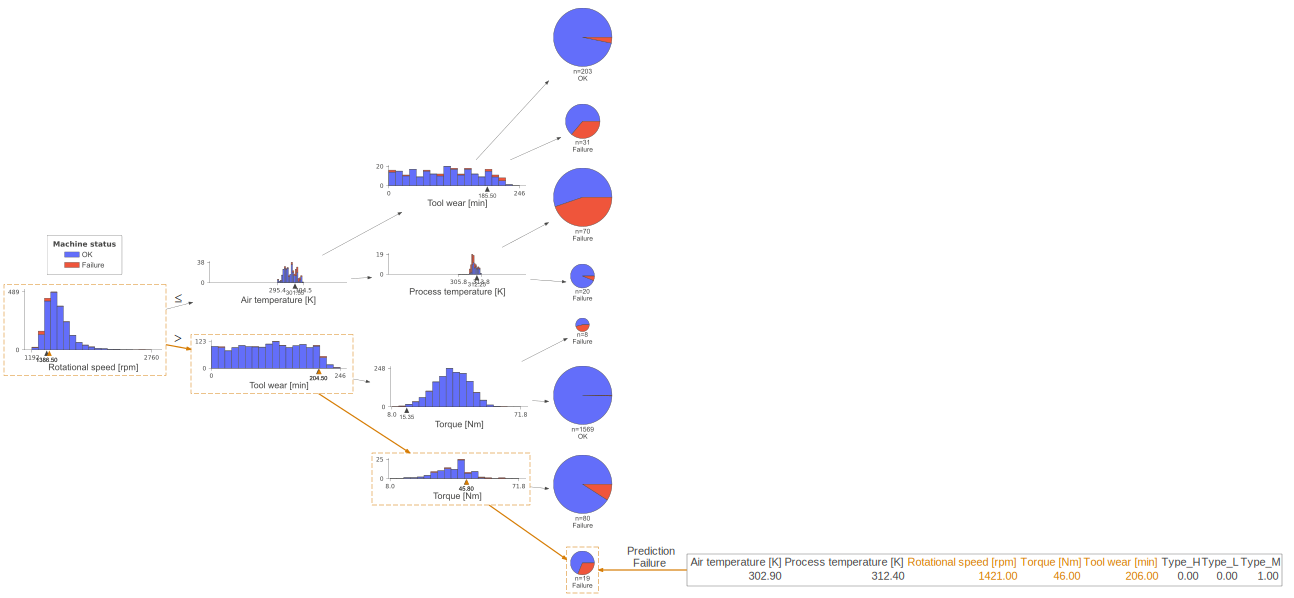

In [14]:
dtreeviz(sk_dtree, orientation ='LR', X = X_FN, colors={'classes': colors_for_up_to_2_classes})

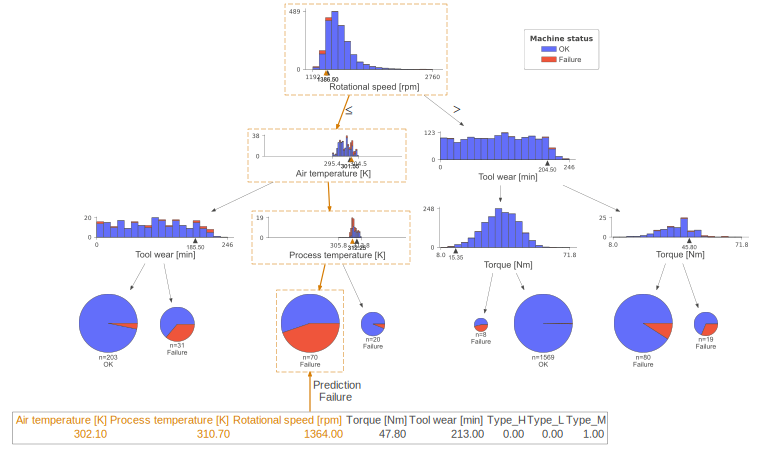

In [15]:
dtreeviz(sk_dtree, orientation ='TD', X = X_TN, colors={'classes': colors_for_up_to_2_classes})

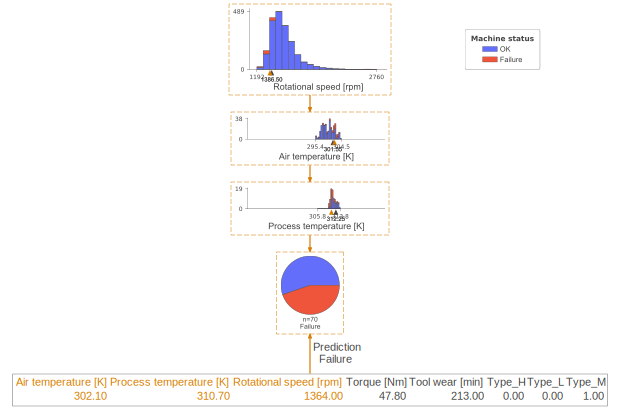

In [16]:
dtreeviz(sk_dtree, orientation ='TD', X = X_TN, show_just_path=True, colors={'classes': colors_for_up_to_2_classes})

# Decision Tree Classifier - Grid Search and Cross Validation

In [17]:
tree_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}
tree_clf_cv = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"), tree_params, scoring="f1", cv=5)
tree_clf_cv = tree_clf_cv.fit(X_train, y_train)

In [18]:
tree_clf_cv.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0}

In [19]:
y_train_pred_cv = tree_clf_cv.predict(X_train)
y_test_pred_cv = tree_clf_cv.predict(X_test)

print("------- Train set -------")
print(f"Precision: {precision_score(y_train, y_train_pred_cv)}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv)}")
print(f"F1: {f1_score(y_train, y_train_pred_cv)}")

print("------- Test set -------")
print(f"Precision: {precision_score(y_test, y_test_pred_cv)}")
print(f"Recall: {recall_score(y_test, y_test_pred_cv)}")
print(f"F1: {f1_score(y_test, y_test_pred_cv)}")

------- Train set -------
Precision: 1.0
Recall: 1.0
F1: 1.0
------- Test set -------
Precision: 0.71875
Recall: 0.6764705882352942
F1: 0.696969696969697


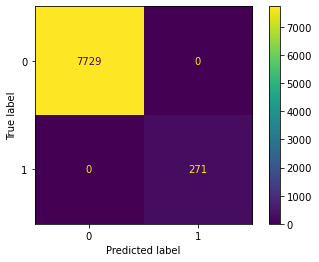

In [20]:
cm_train = confusion_matrix(y_train, y_train_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=tree_clf_cv.classes_)
disp.plot()

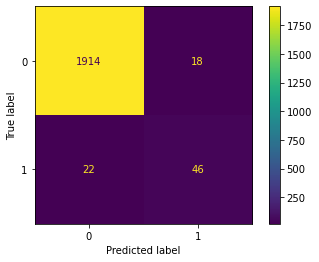

In [21]:
cm_test = confusion_matrix(y_test, y_test_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=tree_clf_cv.classes_)
disp.plot()

In [22]:
sk_dtree_cv = ShadowSKDTree(tree_clf_cv.best_estimator_, X_test, y_test, features, target_name="Machine status", class_names=["OK","Failure"])

In [23]:
dtreeviz(sk_dtree_cv, colors={'classes': colors_for_up_to_2_classes})

c:\Users\Henning\miniconda3\envs\predictive_maintenance\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



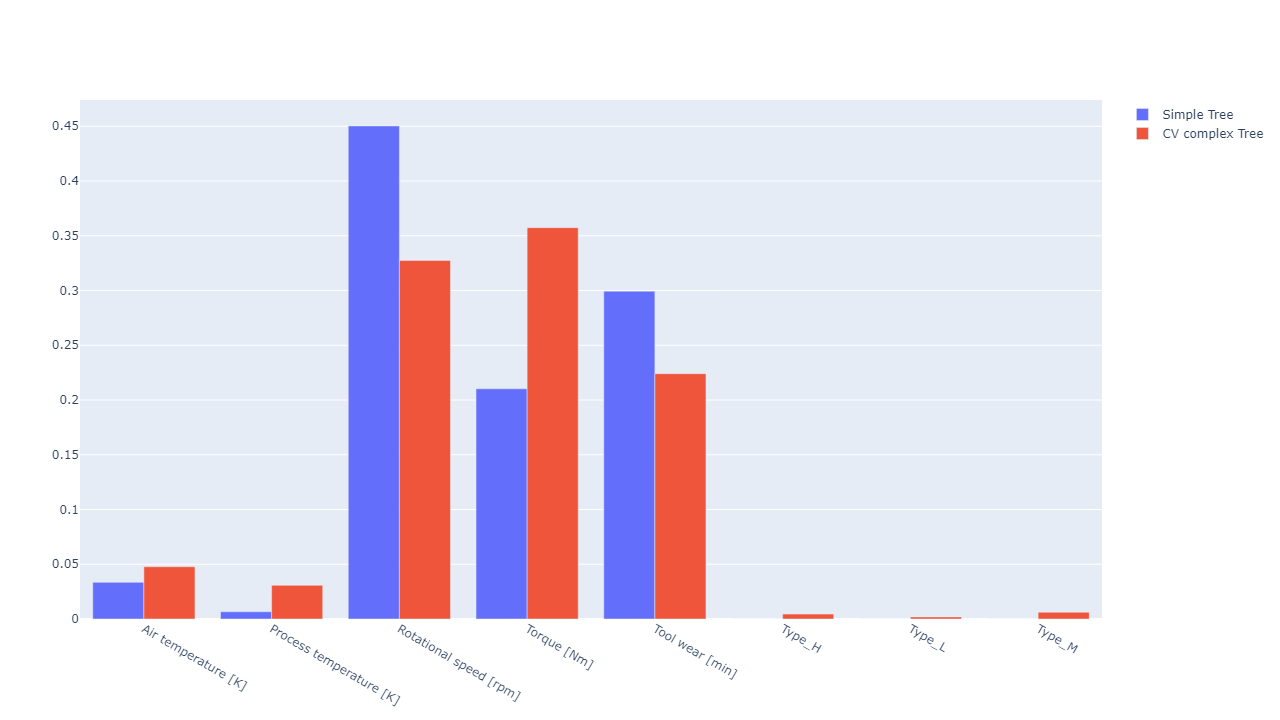

In [24]:
feature_importance_cv = pd.DataFrame({"name": X_train.columns, "importance": tree_clf_cv.best_estimator_.feature_importances_})
fig = go.Figure()
fig.add_trace(go.Bar(x=feature_importance["name"], y=feature_importance["importance"], name="Simple Tree"))
fig.add_trace(go.Bar(x=feature_importance_cv["name"], y=feature_importance_cv["importance"], name="CV complex Tree"))
plot_figure(fig)